# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("/ocean/projects/asc170022p/singla/ExplainingBBSmoothly/")
import yaml
from utils import *
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import scipy.misc as scm
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
np.random.seed(0)

In [2]:
main_dir = '/ocean/projects/asc170022p/singla/ExplainingBBSmoothly'

# Get classifier training config

In [3]:
config = os.path.join(main_dir, 'configs/Step_1_StanfordCheXpert_Classifier_256.yaml')
config = yaml.load(open(config))
for k in config.keys():
    print(k, config[k])
categories = config['categories'].split(',')

('output_folder_name', 'Classifier_Output_MIMIC')
('partition', 'test')
('feature_names', 'dense_2,dense_3,dense_4')
('image_dir', '/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/StanfordCheXpert')
('output_csv', '/ocean/projects/asc170022p/singla/ExplainingBBSmoothly/data/MIMIC_CXR_PA_AP_views_image_report_labels.csv')
('do_center_crop', True)
('batch_size', 400)
('num_channel', 1)
('epochs', 10)
('seed', 0)
('classifier_type', 'DenseNet')
('training_columns_to_repeat', '')
('uncertain_label', 0)
('categories', 'Lung Lesion,Pleural Effusion,Edema,Cardiomegaly,Consolidation,Support Devices,No Finding,Pneumonia,Fracture,Atelectasis,Pneumothorax,Enlarged Cardiomediastinum,Lung Opacity,Pleural Other')
('crop_size', 225)
('num_class', 14)
('name', 'StanfordCheXpert_256')
('ckpt_dir_continue', 'output/classifier/StanfordCheXpert_256')
('use_output_csv', True)
('output_csv_names_column', 'lateral_512_jpeg')
('feature', False)
('path_column', 'Path')
('train', '/ocean/projects/asc17

# Check classifier on MIMIC dataset - test set

In [4]:
output_dir = os.path.join(main_dir,config['log_dir'], config['name'], config['output_folder_name'])
print(output_dir)

/ocean/projects/asc170022p/singla/ExplainingBBSmoothly/output/classifier/StanfordCheXpert_256/Classifier_Output_MIMIC


In [5]:
# Read classifier output
train_or_test = config['partition']
names = np.load(os.path.join(output_dir, 'name_'+train_or_test+'.npy'),allow_pickle=True)
prediction_y = np.load(os.path.join(output_dir, 'prediction_y_'+train_or_test+'.npy'))
true_y = np.load(os.path.join(output_dir, 'true_y_'+train_or_test+'.npy'))
print(names.shape, prediction_y.shape, true_y.shape)
print('True labels: ', np.unique(true_y))

((215200,), (215200, 14), (215200, 14))
('True labels: ', array([0., 1.], dtype=float32))


In [6]:
# Compute Metrics
for i in [1,2,3]:
    pred_y =  (prediction_y[:,i]>0.5).astype(int)
    print(categories[i], i)
    print("ROC-AUC: ", roc_auc_score(true_y[:,i], prediction_y[:,i]))
    print("Accuracy: ", accuracy_score(true_y[:,i],pred_y))
    print("Recall: ", recall_score(true_y[:,i], pred_y))
    tp = np.sum((prediction_y[true_y[:,i] == 1,i]>0.5).astype(int))
    print("Stats: ", np.unique(true_y[:,i], return_counts=True), tp)
    print(confusion_matrix(true_y[:,i],  pred_y))

('Pleural Effusion', 1)
('ROC-AUC: ', 0.8658145410469027)
('Accuracy: ', 0.7574814126394052)
('Recall: ', 0.8485785271303128)
('Stats: ', (array([0., 1.], dtype=float32), array([162473,  52727])), 44743)
[[118267  44206]
 [  7984  44743]]
('Edema', 2)
('ROC-AUC: ', 0.853515091026822)
('Accuracy: ', 0.7722537174721189)
('Recall: ', 0.7812955714176069)
('Stats: ', (array([0., 1.], dtype=float32), array([189142,  26058])), 20359)
[[145830  43312]
 [  5699  20359]]
('Cardiomegaly', 3)
('ROC-AUC: ', 0.7646970077741333)
('Accuracy: ', 0.6134386617100371)
('Recall: ', 0.8118751275249949)
('Stats: ', (array([0., 1.], dtype=float32), array([175992,  39208])), 31832)
[[100180  75812]
 [  7376  31832]]


# Select a  class to create explanation

In [25]:
current_index = 3
name = categories[current_index]
print(name)

Cardiomegaly


In [26]:
df_explain = pd.DataFrame()
df_explain['names'] = names
df_explain[name] = true_y[:,current_index]
df_explain[name+'_prob'] = prediction_y[:,current_index]
df_explain['bin'] = np.floor(df_explain[name+'_prob'].astype('float') * 10).astype('int')
df_explain = df_explain.drop_duplicates()
print(df_explain.shape)
print(np.unique(df_explain['bin'], return_counts=True))
df_explain.head(2)

(215200, 4)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([27153, 28219, 20711, 16656, 14817, 14258, 14752, 16498, 21586,
       40550]))


,names,Cardiomegaly,Cardiomegaly_prob,bin
0,/ocean/projects/asc170022p/shared/Data/chestXR...,0.0,0.063431,0
1,/ocean/projects/asc170022p/shared/Data/chestXR...,0.0,0.084561,0


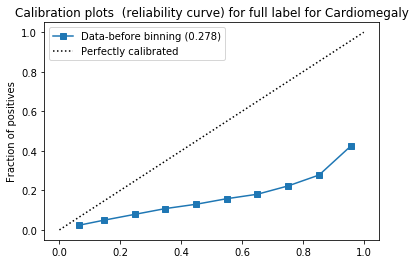

In [27]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,f1_score)
true_label = np.asarray(df_explain[name]).astype(int)
predicted_prob = np.asarray(df_explain[name+'_prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-before binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
#plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for full label for '+ name)
plt.legend()
plt.show()

# Create Training Data for the Explainer

In [76]:
n = 4000

In [84]:
np.random.seed(0)
for i in range(0,10):
    print i
    df_bin = df_explain.loc[df_explain['bin'] == i]
    df_bin = df_bin.sample(n=n)
    if i == 0:
        df_bin_all = df_bin
    else:
        df_bin_all = pd.concat([df_bin, df_bin_all])
    print(df_bin_all.shape)
    print(np.unique(df_bin[name],return_counts=True))

0
(4000, 4)
(array([0., 1.], dtype=float32), array([3791,  209]))
1
(8000, 4)
(array([0., 1.], dtype=float32), array([3064,  936]))
2
(12000, 4)
(array([0., 1.], dtype=float32), array([2583, 1417]))
3
(16000, 4)
(array([0., 1.], dtype=float32), array([2301, 1699]))
4
(20000, 4)
(array([0., 1.], dtype=float32), array([1911, 2089]))
5
(24000, 4)
(array([0., 1.], dtype=float32), array([1721, 2279]))
6
(28000, 4)
(array([0., 1.], dtype=float32), array([1421, 2579]))
7
(32000, 4)
(array([0., 1.], dtype=float32), array([1206, 2794]))
8
(36000, 4)
(array([0., 1.], dtype=float32), array([ 921, 3079]))
9
(40000, 4)
(array([0., 1.], dtype=float32), array([ 606, 3394]))


In [85]:
print(np.unique(df_bin_all['bin'] ,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]))


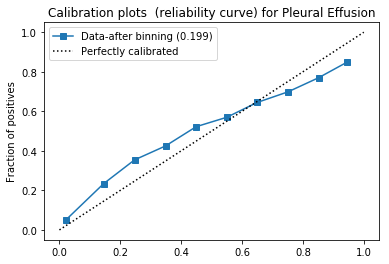

In [86]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_bin_all[name]).astype(int)
predicted_prob = np.asarray(df_bin_all[name+'_prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-after binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+name)
plt.legend()
plt.show()

# [Optional] Create Training Data for the Explainer: Calibrated

In [28]:
n = 4000

In [29]:
for i in range(10):
    print i
    df_bin = df_explain.loc[df_explain['bin'] == i]
    print(df_bin.shape)
    print(np.min(df_bin[name+'_prob']), np.max(df_bin[name+'_prob']))
    print(np.unique(df_bin[name],return_counts=True))
    df_bin_0 = df_explain.loc[(df_explain['bin'] == i) & (df_explain[name] ==0)]
    df_bin_1 = df_explain.loc[(df_explain['bin'] == i) & (df_explain[name] ==1)]
    n_0 = int((1 - (0.1 * i) ) * n)
    if df_bin_0.shape[0] >= n_0:
        df_bin = df_bin_0.sample(n=n_0)
    else:
        df_bin = df_bin_0
        n_0 = df_bin_0.shape[0]
    n_1 = n - n_0
    if df_bin_1.shape[0] >= n_1:
        df_bin = pd.concat([df_bin, df_bin_1.sample(n=n_1)])        
    else:
        df_bin = pd.concat([df_bin, df_bin_1])    
        
    if i == 0:
        df_bin_all = df_bin
    else:
        df_bin_all = pd.concat([df_bin, df_bin_all])
    print(df_bin_all.shape)
    print(np.unique(df_bin[name],return_counts=True))

0
(27153, 4)
(0.0044471323, 0.09999737)
(array([0., 1.], dtype=float32), array([26523,   630]))
(4000, 4)
(array([0.], dtype=float32), array([4000]))
1
(28219, 4)
(0.10000324, 0.19999942)
(array([0., 1.], dtype=float32), array([26828,  1391]))
(8000, 4)
(array([0., 1.], dtype=float32), array([3600,  400]))
2
(20711, 4)
(0.2000001, 0.29999906)
(array([0., 1.], dtype=float32), array([19080,  1631]))
(12000, 4)
(array([0., 1.], dtype=float32), array([3200,  800]))
3
(16656, 4)
(0.30000094, 0.39999563)
(array([0., 1.], dtype=float32), array([14857,  1799]))
(16000, 4)
(array([0., 1.], dtype=float32), array([2800, 1200]))
4
(14817, 4)
(0.4000057, 0.49999973)
(array([0., 1.], dtype=float32), array([12892,  1925]))
(20000, 4)
(array([0., 1.], dtype=float32), array([2400, 1600]))
5
(14258, 4)
(0.5000022, 0.59999335)
(array([0., 1.], dtype=float32), array([12007,  2251]))
(24000, 4)
(array([0., 1.], dtype=float32), array([2000, 2000]))
6
(14752, 4)
(0.6000069, 0.6999946)
(array([0., 1.], dtype=

In [30]:
print(np.unique(df_bin_all['bin'] ,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000]))


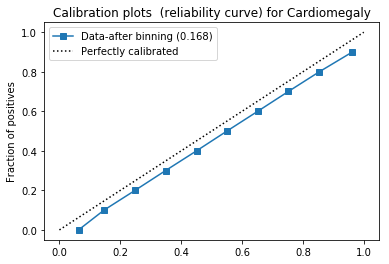

In [31]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_bin_all[name]).astype(int)
predicted_prob = np.asarray(df_bin_all[name+'_prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-after binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+name)
plt.legend()
plt.show()

# Save output to be read by the explainer

In [32]:
name = name.replace(' ', '_')
experiment_dir = os.path.join(main_dir,config['log_dir'], config['name'], 'Explainer_MIMIC_'+name)
print(experiment_dir,name)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

('/ocean/projects/asc170022p/singla/ExplainingBBSmoothly/output/classifier/StanfordCheXpert_256/Explainer_MIMIC_Cardiomegaly', 'Cardiomegaly')


In [33]:
df_temp = df_bin_all[['names', 'bin']]
df_temp.to_csv(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), sep = ' ', index = None, header = None)
print(df_temp.shape)
one_line = str(df_temp.shape[0]) + '\n'
second_line = "0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99\n"
with open(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), 'r+') as fp:
    lines = fp.readlines()     # lines is list of line, each element '...\n'
    lines.insert(0, one_line)  # you can use any index if you know the line index
    lines.insert(1, second_line)
    fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
    fp.writelines(lines) 
fp = open(os.path.join(experiment_dir, 'list_attr_'+name+'.txt'), 'rw')
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
print(fp.readline())
df_bin_all.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ', index = None)


(40000, 2)
40000

0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99

/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/MIMICCXR/2.0.0/files/p17/p17096578/s57569940/view3_lateral_HE_512.jpeg 9

/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/MIMICCXR/2.0.0/files/p12/p12992793/s53329529/view2_lateral_HE_512.jpeg 9

/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/MIMICCXR/2.0.0/files/p15/p15181240/s56046134/view3_lateral_HE_512.jpeg 9

/ocean/projects/asc170022p/shared/Data/chestXRayDatasets/MIMICCXR/2.0.0/files/p10/p10388400/s58237613/view2_lateral_HE_512.jpeg 9

